# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных

**Признаки:**

*   DateCrawled — дата скачивания анкеты из базы
*   VehicleType — тип автомобильного кузова
*   RegistrationYear — год регистрации автомобиля
*   Gearbox — тип коробки передач
*   Power — мощность (л. с.)
*   Model — модель автомобиля
*   Kilometer — пробег (км)
*   RegistrationMonth — месяц регистрации автомобиля
*   FuelType — тип топлива
*   Brand — марка автомобиля
*   Repaired — была машина в ремонте или нет
*   DateCreated — дата создания анкеты
*   NumberOfPictures — количество фотографий автомобиля
*   PostalCode — почтовый индекс владельца анкеты (пользователя)
*   LastSeen — дата последней активности пользователя

**Целевой признак:**

*   Price — цена (евро)

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import time
from lightgbm import LGBMRegressor
import numpy as np
from sklearn.dummy import DummyRegressor
from datetime import datetime

!pip install scikit-learn --upgrade
!pip install catboost

from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# загрузка данных
try:
    data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Стоимость автомобиля/autos.csv')
except:
    data = pd.read_csv('/datasets/autos.csv')

In [3]:
old_size = data.shape[0]

In [4]:
# чтобы все столбцы выводились на экран
pd.set_option('display.max_columns', None)

# функция первичного анализа
def first_analysis(df):
  columns = df.columns.tolist() # формируем список из названий столбцов

  for col in columns: # для каждого  выполняем следующие команды
    print("-"*60) # линия разделитель
    print(col) # печатаем названия столбца
    print('Тип данных:', df[col].dtypes) # выводим тип данных в этом столбце
    print(f'Количество пустых ячеек: {df[col].isna().sum()} ({df[col].isna().sum()/df.shape[0]*100}%)') # выводим количество пустых ячеек в абсолютных значениях, а также в процентах
    print('Уникальные значения', df[col].unique()) # выводим список уникальных значений
  # далее по всей таблице
  print()
  print('Количество явных дубликатов:', df.duplicated().sum()) # Выводим количество явных дубликатов
  print()
  print('Первые пять строк таблицы данных')
  print()
  display(df.head()) # печатаем первые пять строк таблицы
  print('\n'*2)
  display(df.describe()) # выводим статистическую информацию по каждому столбцу
  print('\n'*2)
  df.hist(figsize=(15, 20)); # строим гистограммы для каждой колонки
  print('\n'*2)
  display(df.corr().round(2)) # строим корреляционную матрицу
  print('\n'*2)
  pd.plotting.scatter_matrix(df, figsize=(12, 9)); # выводим корреляционную матрицу графически

------------------------------------------------------------
DateCrawled
Тип данных: object
Количество пустых ячеек: 0 (0.0%)
Уникальные значения ['2016-03-24 11:52:17' '2016-03-24 10:58:45' '2016-03-14 12:52:21' ...
 '2016-03-21 09:50:58' '2016-03-14 17:48:27' '2016-03-19 18:57:12']
------------------------------------------------------------
Price
Тип данных: int64
Количество пустых ячеек: 0 (0.0%)
Уникальные значения [  480 18300  9800 ... 12395 18429 10985]
------------------------------------------------------------
VehicleType
Тип данных: object
Количество пустых ячеек: 37490 (10.57936783409384%)
Уникальные значения [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
------------------------------------------------------------
RegistrationYear
Тип данных: int64
Количество пустых ячеек: 0 (0.0%)
Уникальные значения [1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.00,0.03,0.16,-0.33,0.11,NaN,0.08
RegistrationYear,0.03,1.00,-0.00,-0.05,-0.01,NaN,-0.00
Power,0.16,-0.00,1.00,0.02,0.04,NaN,0.02
Kilometer,-0.33,-0.05,0.02,1.00,0.01,NaN,-0.01
RegistrationMonth,0.11,-0.01,0.04,0.01,1.00,NaN,0.01
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.08,-0.00,0.02,-0.01,0.01,NaN,1.00


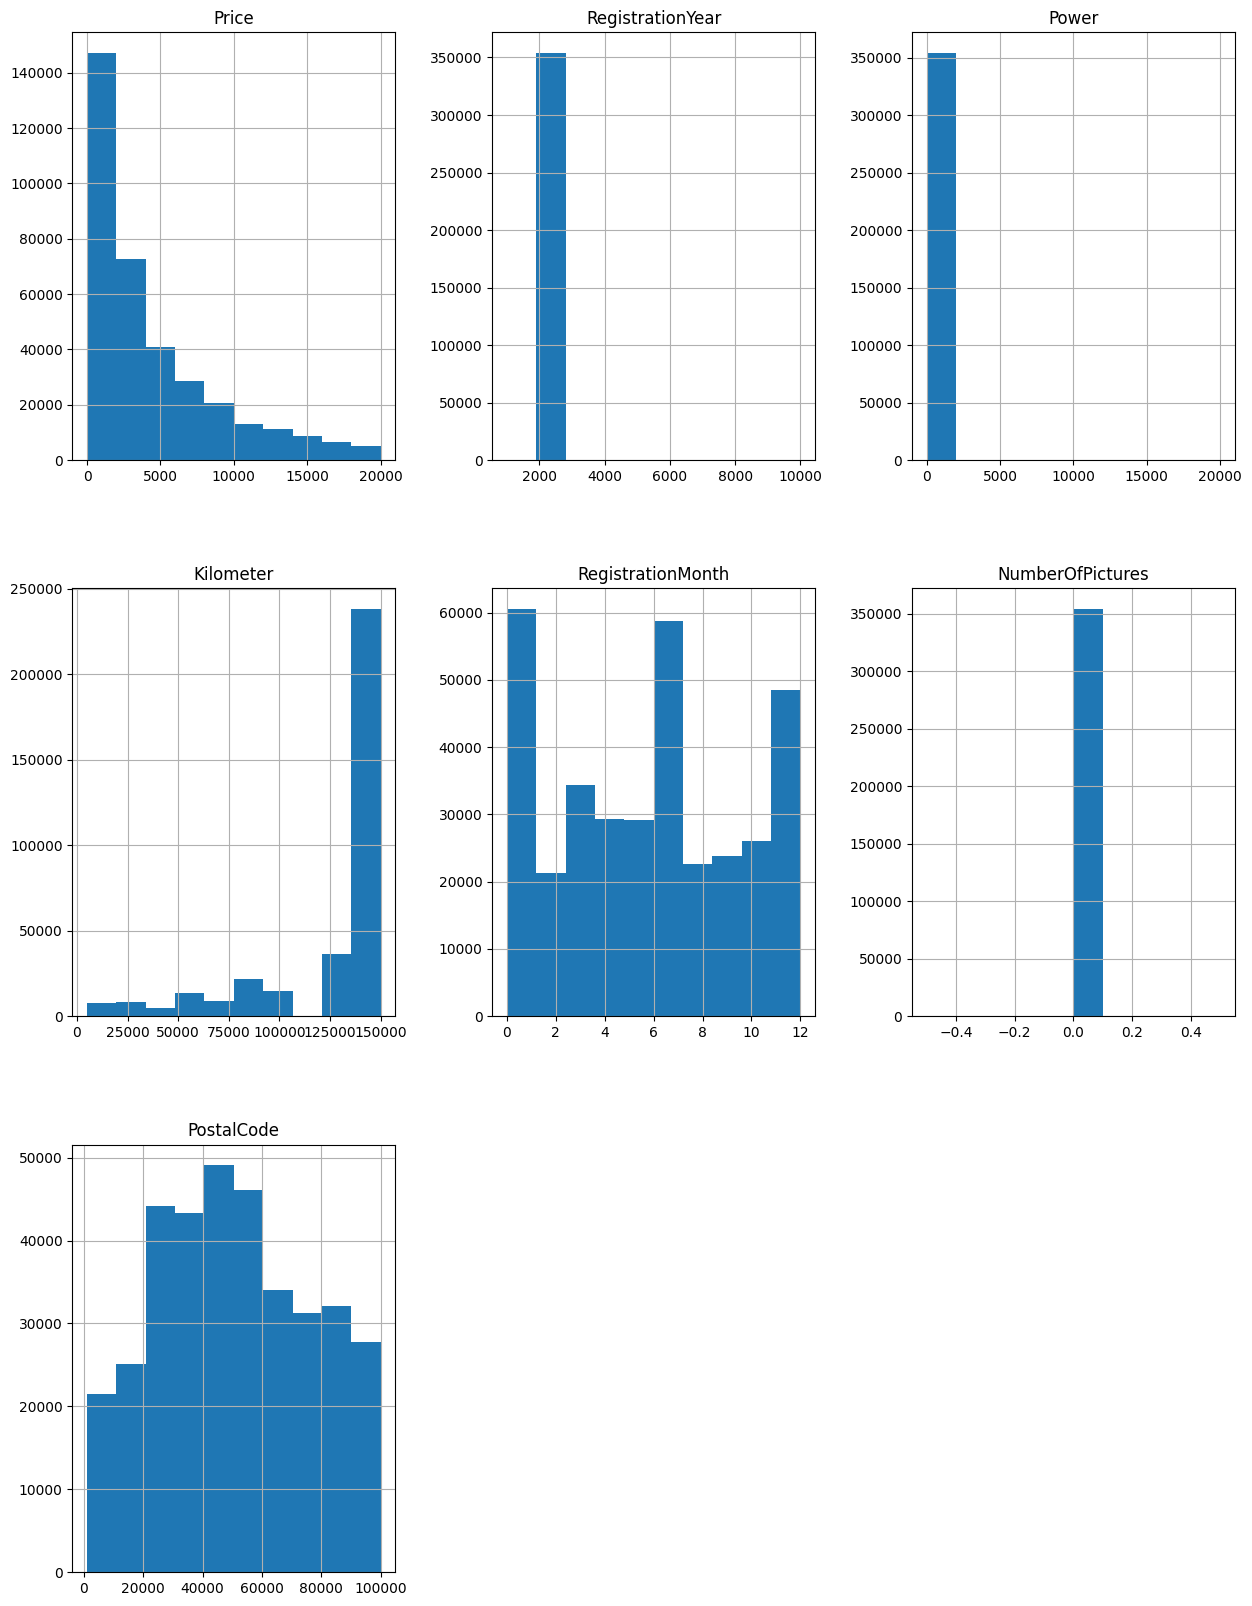

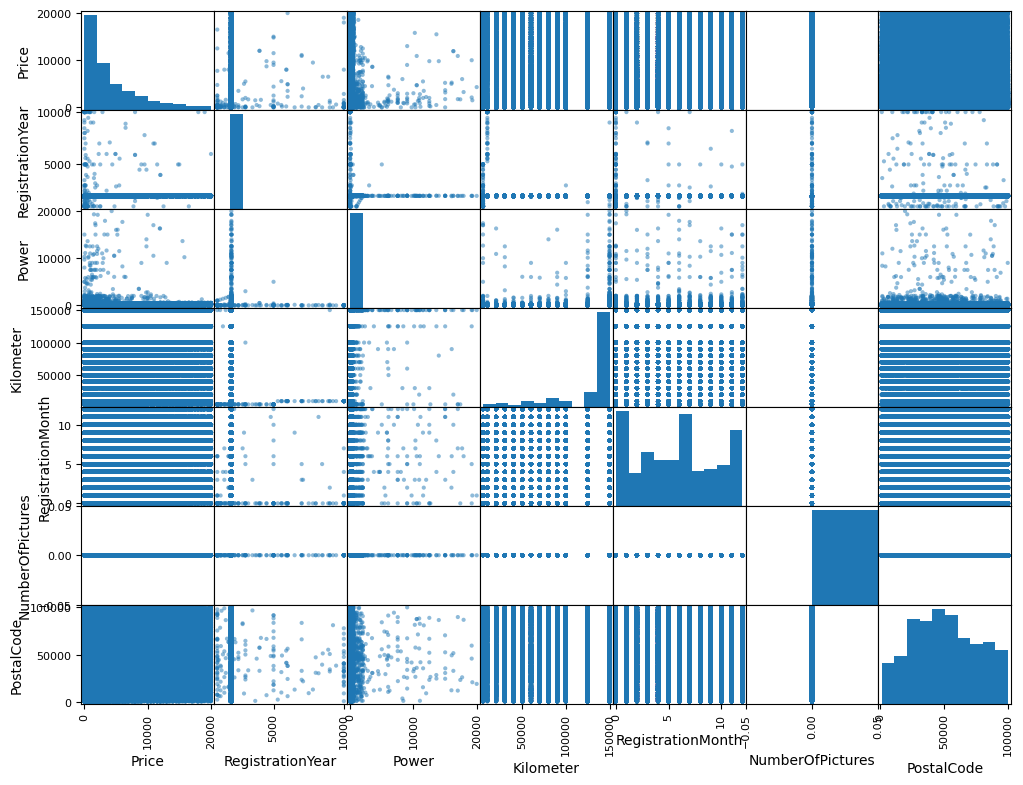

In [5]:
# применяем функцию первичного анализа к нашим данным
first_analysis(data)

Как видим из первичного анализа в данных присутсвуют пропуски. Сократим количество пропущенных ячеек.
1.   В столбце VehicleType заполним пустые ячейки other, так как мы не можем угадать тип кузова авто, но часть данных заполненна типом other - воспользуемся этим моментом
2.   В столбце FuelType пустые ячейки заменим на petrol, исходя из того, что подавляющее большинство автомобилей использует в качестве топлива бензин, а также предполагая, что при заполнении анкеты владелец бы точно указал вид топлива если бы это был не бензин
3.   Пустые ячейки столбца Repaired заполним no, предполагая что если бы машина была в ремонте то владелец ответственно указал бы на этот факт

Часть пустых ячеек в колонках Gearbox и Model мы к сожелению не можем заполнить, так как это будет угадывание. И такие данные с пустыми ячейками придется удалить.


In [6]:
data['VehicleType'] = data['VehicleType'].fillna('other')
data['FuelType'] = data['FuelType'].fillna('petrol')
data['Repaired'] = data['Repaired'].fillna('no')

Подсчитаем долю строк с пустыми ячейками в колонках Gearbox и Model.

In [7]:
data[data['Gearbox'].isna() | data['Model'].isna()]['DateCrawled'].count() / data.shape[0]

0.09991562467371581

Таких данных менее 10%, можно смело их удалить.

In [8]:
data.dropna(inplace = True)

Проверим наличие пустых ячеек.

In [9]:
data.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

Также первичный анализ показал наличие явных дубликатов. Выведем их на экран.

In [10]:
data.duplicated().sum()

5

In [11]:
data[data.duplicated(keep=False)]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
189060,2016-04-04 22:50:44,13000,sedan,2008,manual,143,a4,125000,9,gasoline,audi,no,2016-04-04 00:00:00,0,65428,2016-04-05 12:30:14
194008,2016-04-04 22:50:44,13000,sedan,2008,manual,143,a4,125000,9,gasoline,audi,no,2016-04-04 00:00:00,0,65428,2016-04-05 12:30:14
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


Как видим информация полностью дублируется. Удаляем дубликаты.

In [12]:
data = data.drop_duplicates()

Проверем даты регистрации автомобиля и даты создания обьявления. Для этого преобразуем формат строковый в даты и сформируем отдельный столбец с годом.

In [13]:
data['DateCreated'] = pd.to_datetime(data['DateCreated'])
data['DateCreated_year'] = data['DateCreated'].dt.year

In [14]:
data[data['DateCreated_year'] < data['RegistrationYear']]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,DateCreated_year
22,2016-03-23 14:52:51,2900,other,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23,0,49716,2016-03-31 01:16:33,2016
26,2016-03-10 19:38:18,5555,other,2017,manual,125,c4,125000,4,petrol,citroen,no,2016-03-10,0,31139,2016-03-16 09:16:46,2016
48,2016-03-25 14:40:12,7750,other,2017,manual,80,golf,100000,1,petrol,volkswagen,no,2016-03-25,0,48499,2016-03-31 21:47:44,2016
51,2016-03-07 18:57:08,2000,other,2017,manual,90,punto,150000,11,gasoline,fiat,yes,2016-03-07,0,66115,2016-03-07 18:57:08,2016
57,2016-03-10 20:53:19,2399,other,2018,manual,64,other,125000,3,petrol,seat,no,2016-03-10,0,33397,2016-03-25 10:17:37,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354099,2016-03-17 15:45:46,4900,other,2017,manual,69,polo,150000,12,gasoline,volkswagen,no,2016-03-17,0,32791,2016-03-25 17:51:29,2016
354112,2016-03-11 15:49:51,3600,other,2017,manual,86,transit,150000,5,gasoline,ford,no,2016-03-11,0,32339,2016-03-12 05:45:02,2016
354140,2016-03-29 16:47:29,1000,other,2017,manual,101,a4,150000,9,petrol,audi,no,2016-03-29,0,38315,2016-04-06 02:44:27,2016
354203,2016-03-17 00:56:26,2140,other,2018,manual,80,fiesta,150000,6,petrol,ford,no,2016-03-17,0,44866,2016-03-29 15:45:04,2016


Строк с датами регистрации автомобиля позже чем год создания обьявления 11033, к сожелению придеться с ними расстаться.

In [15]:
data = data[data['DateCreated_year'] > data['RegistrationYear']]

Для формирования модели предсказания цены автомобиля у нас имеються лишние данные, выделим колонки которые никак не влияют на стоимость авто.

Такие колонки: DateCrawled, DateCreated, NumberOfPictures, LastSeen. Удалим их.

In [16]:
data = data.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'LastSeen', 'DateCreated_year'], axis = 1)

Разделим наши данные на категориальные и числовые признаки.

In [17]:
numeric = ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'PostalCode']
categorical = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

В данных встерчаются аномальные значения например цена = 0. Построим гистограммы и диаграммы размаха для каждого столбца.

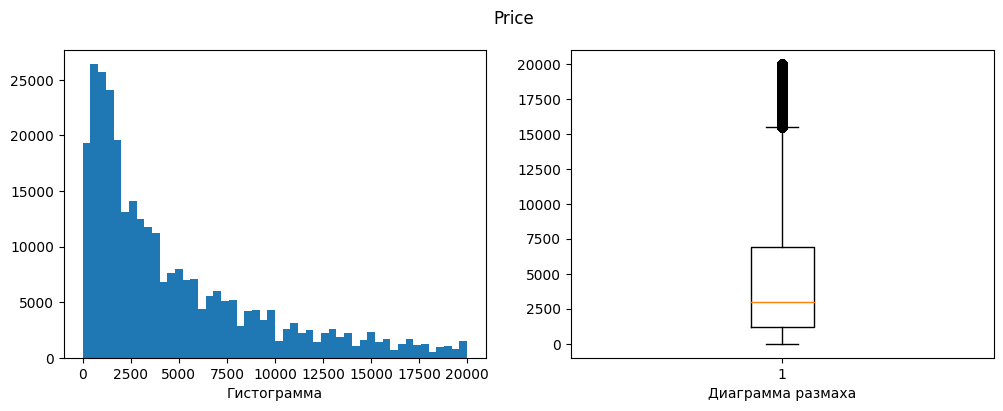

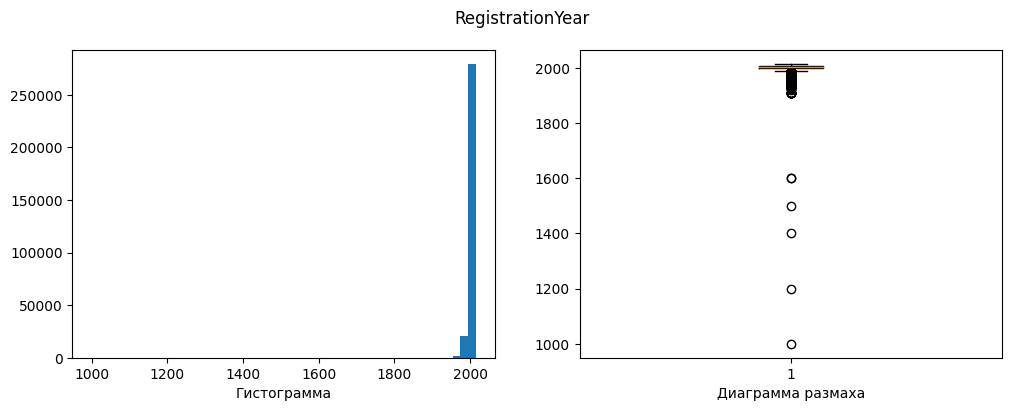

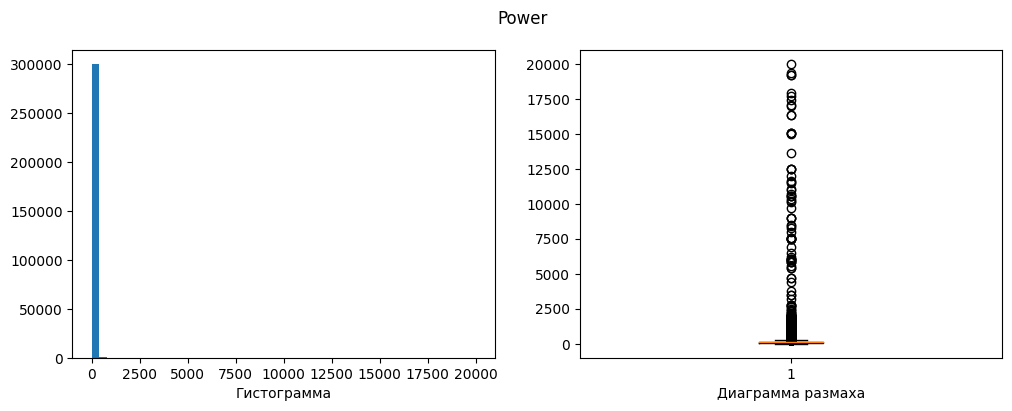

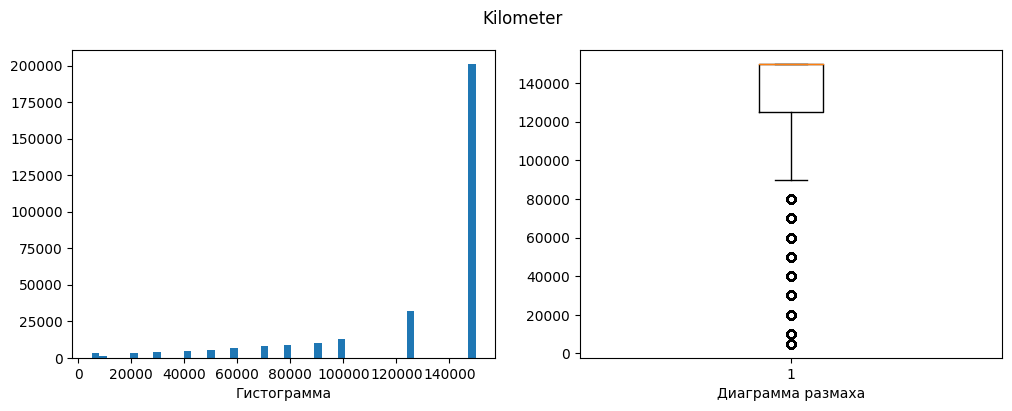

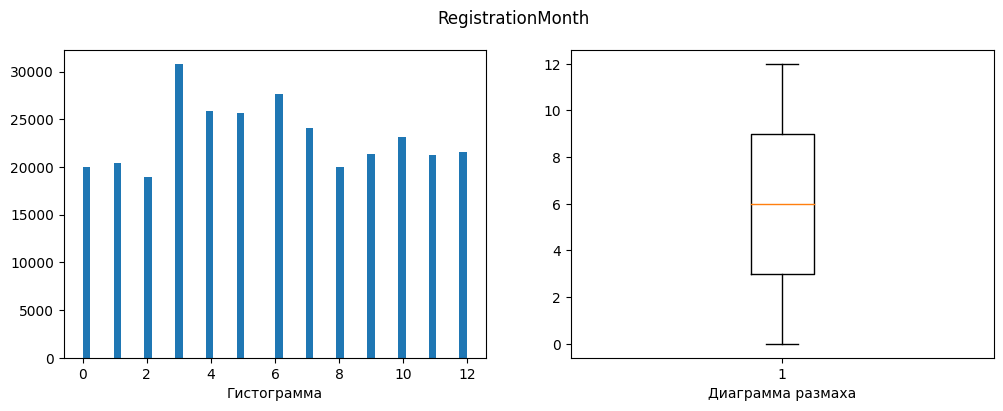

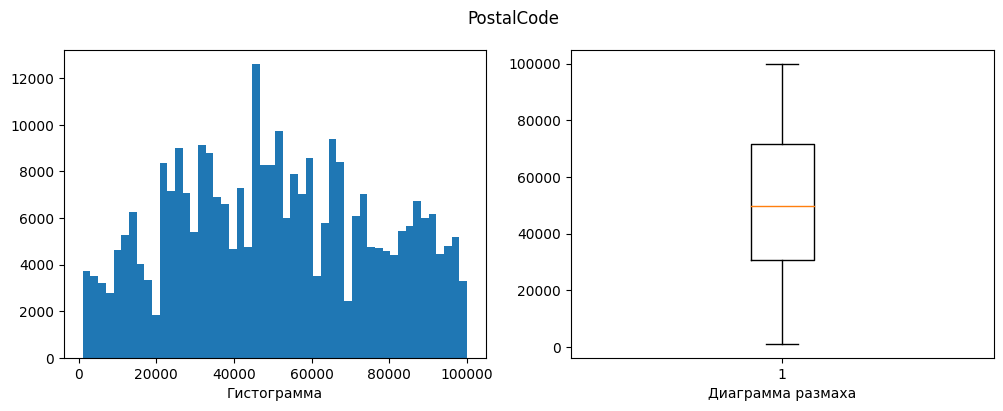

In [18]:
for i in data[numeric]:
  fig, ax = plt.subplots(1 ,2, figsize=(12,4))
  fig.suptitle(i)
  ax[0].hist(data[i], bins=50);
  ax[1].boxplot(x=data[i]);
  ax[0].set_xlabel('Гистограмма')
  ax[1].set_xlabel('Диаграмма размаха')
  data[i].describe()

Как видно по построенным графикам у нас есть аномалии среди данных.

1.   Авто с ценой = 0
2.   Год регистрации от 1000 до 9000
3.   Мощности двигателя более 500 л.с. (исходя из того что на рынке авто двигатели с мощностью более 500 л.с. эксклюзивные варианты)

Посмотрим сколько их, и очистим от этих аномалий наши данные.

Аномалии в столбце месяц регистрации = 0, оставляем, предполагая что нулевые значения указаны по умолчанию, а владелец при заполнении анкеты пропустил данный пункт.



In [19]:
data[data['Price'] <= 100]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
7,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,19348
89,1,sedan,1995,manual,113,e_klasse,150000,4,gasoline,mercedes_benz,no,40589
152,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,27432
231,0,wagon,2001,manual,115,mondeo,150000,0,petrol,ford,no,57627
268,1,sedan,1990,manual,90,80,70000,6,petrol,audi,no,55122
...,...,...,...,...,...,...,...,...,...,...,...,...
354238,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,no,33659
354248,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,no,42329
354277,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes,22559
354309,99,small,1999,manual,60,arosa,150000,1,petrol,seat,yes,91301


Всего позиций в данных с ценой авто менее 100 евро 8088. У нас данных 319 тысяч, поэтому такие аномалии можно смело удалять.

In [20]:
data = data[data['Price'] > 100]

In [21]:
data[data['RegistrationYear'] < 1950]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
1928,7000,suv,1945,manual,48,other,150000,2,petrol,volkswagen,no,58135
18224,7999,other,1500,manual,224,impreza,5000,3,petrol,subaru,no,53577
23750,3900,wagon,1910,manual,90,passat,150000,0,petrol,volkswagen,no,88662
33638,5400,small,1937,manual,0,other,20000,3,petrol,opel,no,7907
34055,2900,small,1937,manual,34,other,40000,7,petrol,ford,yes,33378
48958,600,small,1910,manual,0,agila,5000,0,petrol,opel,yes,61279
52323,500,small,1945,manual,1000,astra,100000,5,petrol,opel,yes,1723
56241,950,other,1400,manual,1400,golf,125000,4,petrol,volkswagen,no,50389
62803,3400,small,1910,manual,90,beetle,90000,4,petrol,volkswagen,no,34308
68185,19900,convertible,1932,manual,18,other,5000,2,petrol,bmw,no,99735


In [22]:
data[data['RegistrationYear'] < 1950].shape[0]

48

In [23]:
data[data['RegistrationYear'] > 2023]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode


In [24]:
data[data['RegistrationYear'] > 2023].shape[0]

0

Удалим аномальные данные по дате регистрации.

In [25]:
data = data[(data['RegistrationYear'] > 1950) & (data['RegistrationYear'] < 2023)]

Удалим анамалии по мощности двигателя

In [26]:
data[data['Power'] > 500].shape[0]

316

In [27]:
data = data[data['Power'] < 500]

Проверим сколько осталось данных от начальных

In [28]:
print(f'{round((data.shape[0] / old_size), 3) * 100}%')

82.5%


Удалили 17.5% данных - в принципе нормально.

Построим схему корреляции для числовых значений.

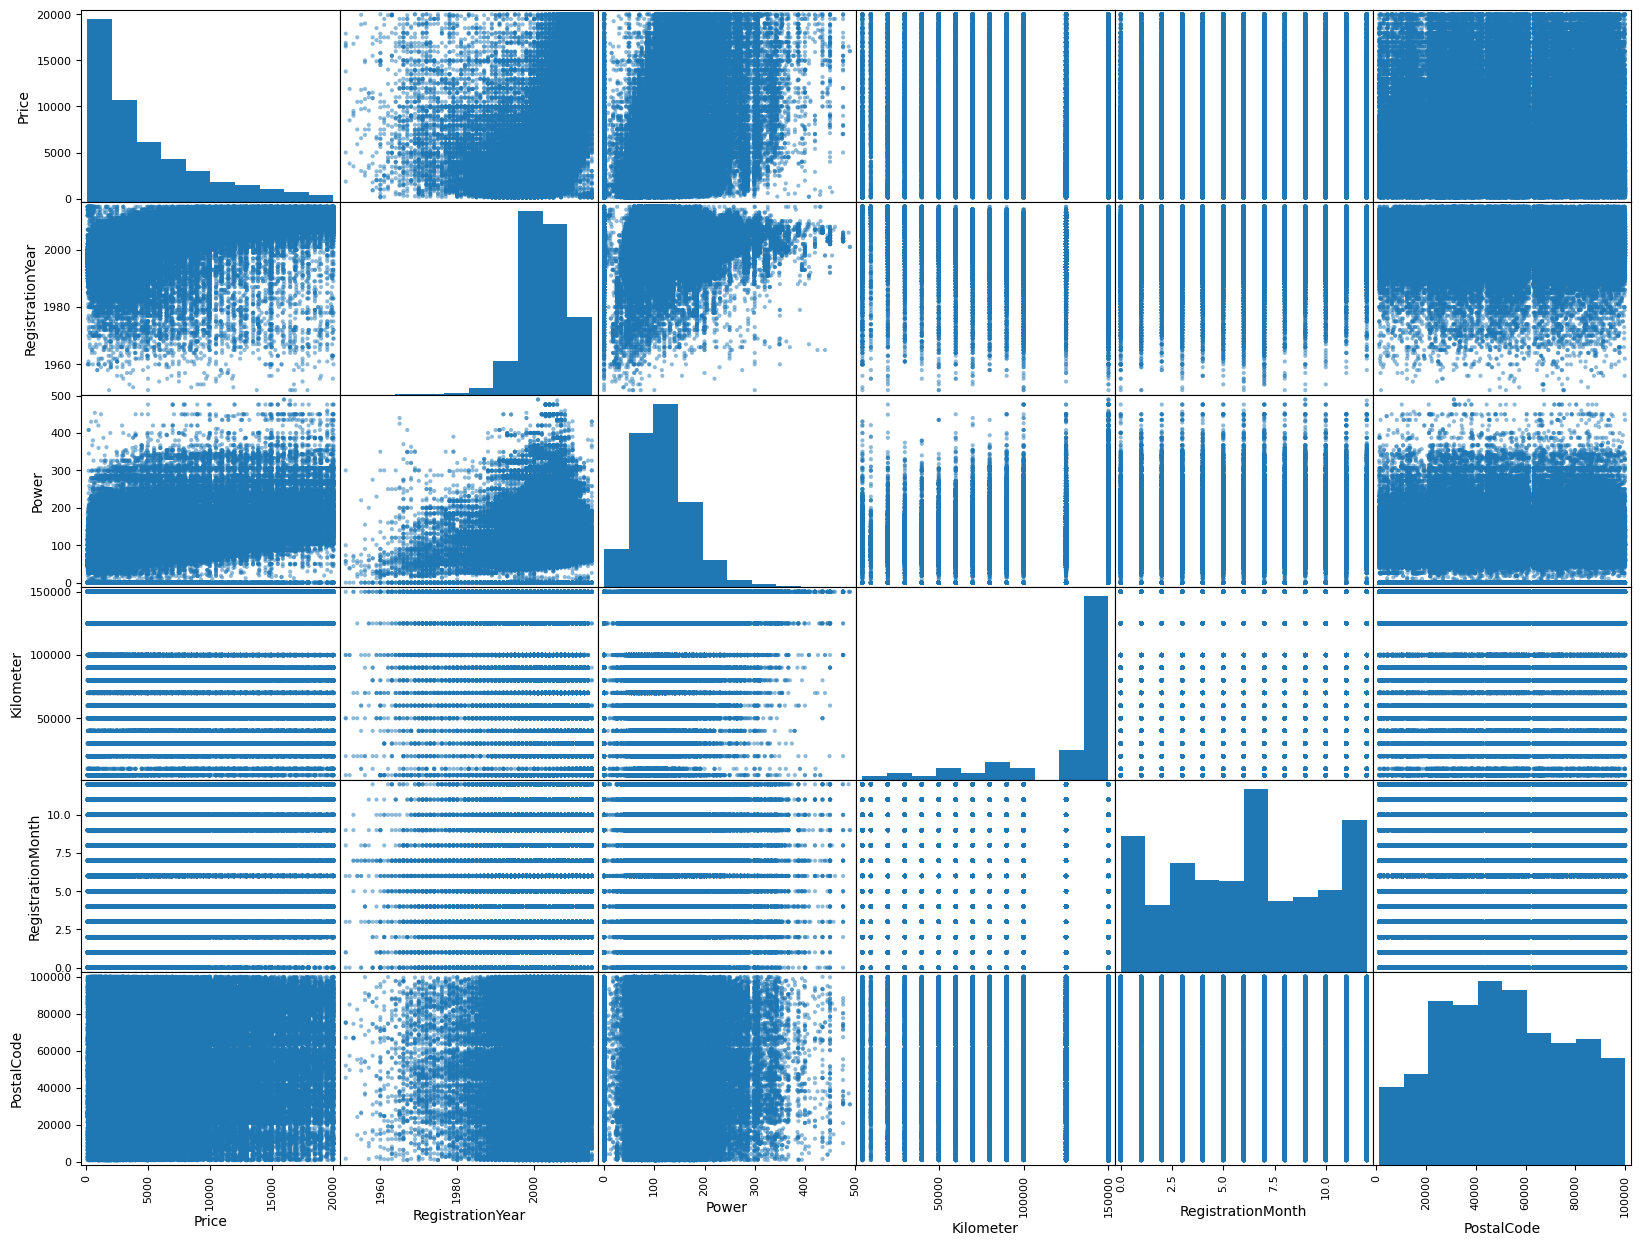

In [29]:
pd.plotting.scatter_matrix(data[numeric], figsize=(20, 15));

Анализируя графики можно отметить что у увеличением даты регистрации автомобиля цена растет, т.е. чем нове автомобиль тем он дороже стоит. Также цена находиться в прямой зависимости от мощности двигателя. По остальным признаком связей не выявлено.

**Вывод:** Загружены и изучены данные. Там где возможно пропуски были заполнены, оставшиеся строки с пустыми ячейками удалены. Очищенны данные от аномалий. Также были удалены лишние столбцы, которые не влияют на целевой показатель.

## Обучение моделей

In [30]:
# введем значение random state
RANDOM_STATE = 55555

In [31]:
# отделим признаки от целевых
# разделим выборки на обучающую и тестовую
target = data['Price']
features = data.drop('Price', axis=1)

features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=0.4, random_state=RANDOM_STATE)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_test, target_valid_test, test_size=0.50, random_state=RANDOM_STATE)

In [32]:
numeric = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'PostalCode'] # убрали название колонки Price
categorical = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

Так как у нас будет три модели и при этом в каждой модели по своему будут предобрабатываться признаки, продублируем их для каждой модели.

In [33]:
features_train_cbr = features_train
features_valid_cbr = features_valid
features_test_cbr = features_test

features_train_lgbm = features_train
features_valid_lgbm = features_valid
features_test_lgbm = features_test

features_train_lr = features_train
features_valid_lr = features_valid
features_test_lr = features_test

Теперь все готово для подбора и обучение модели.

**Регрессионная модель - CatBoost**

In [34]:
cbr = CatBoostRegressor(loss_function='RMSE', cat_features=categorical, verbose=0, random_seed=RANDOM_STATE)

parameters = {'iterations': [100, 300, 500],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8]}

grid_cbr = GridSearchCV(estimator=cbr, param_grid = parameters, cv = 2, n_jobs=-1)

In [35]:
grid_cbr.fit(features_train_cbr, target_train)

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostRegressor object at 0x79a72959abf0>,
             n_jobs=-1,
             param_grid={'depth': [2, 4, 6, 8], 'iterations': [100, 300, 500],
                         'learning_rate': [0.03, 0.1]})

In [36]:
 print('Лучшие гиперпараметры CatBoostRegressor',grid_cbr.best_params_)

Лучшие гиперпараметры CatBoostRegressor {'depth': 8, 'iterations': 500, 'learning_rate': 0.1}


In [37]:
model = CatBoostRegressor(loss_function="RMSE", iterations=500, depth=8, learning_rate=0.1, cat_features=categorical, verbose=0, random_seed=RANDOM_STATE)

tic = time.time()
model.fit(features_train_cbr, target_train)
toc = time.time()

In [38]:
time_taken_fit_cbr = round(toc - tic, 2)

In [39]:
tic = time.time()
pred_valid = grid_cbr.predict(features_valid_cbr)
toc = time.time()

In [40]:
time_taken_pred_cbr = round(toc - tic, 2)

In [41]:
rmse_cb = round((mean_squared_error(target_valid, pred_valid))**0.5, 2)

In [42]:
# сформируем массив, где будем сохранять полученные результаты
table = []
table.append(['CatBoostRegressor', rmse_cb, time_taken_fit_cbr, time_taken_pred_cbr])

**Регрессионная модель - LightGBM**

Для запуски машинного обучения потребуется преобразовать категориальные признаки.

In [43]:
features_train_lgbm[categorical] = features_train_lgbm[categorical].astype('category')
features_valid_lgbm[categorical] = features_valid_lgbm[categorical].astype('category')
features_test_lgbm[categorical] = features_test_lgbm[categorical].astype('category')

In [44]:
lgbm = LGBMRegressor(metric=['rmse'], cat_features=categorical, verbose=0, seed=RANDOM_STATE)

parameters = {'num_iterations': [100, 500],
    'bagging_fraction': [0.8, 1],
        'feature_fraction': [0.8, 1],
        'min_data_in_leaf': [20, 50]}

grid_lgbm = GridSearchCV(estimator=lgbm, param_grid = parameters, cv = 2, n_jobs=-1)

In [45]:
grid_lgbm.fit(features_train_lgbm, target_train)

[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032555 seconds.
You can set `force_col_wise=true` to remove the overhead.


GridSearchCV(cv=2,
             estimator=LGBMRegressor(cat_features=['VehicleType', 'Gearbox',
                                                   'Model', 'FuelType', 'Brand',
                                                   'Repaired'],
                                     metric=['rmse'], seed=55555, verbose=0),
             n_jobs=-1,
             param_grid={'bagging_fraction': [0.8, 1],
                         'feature_fraction': [0.8, 1],
                         'min_data_in_leaf': [20, 50],
                         'num_iterations': [100, 500]})

In [46]:
 print('Лучшие гиперпараметры LGBMRegressor',grid_lgbm.best_params_)

Лучшие гиперпараметры LGBMRegressor {'bagging_fraction': 0.8, 'feature_fraction': 0.8, 'min_data_in_leaf': 20, 'num_iterations': 500}


In [47]:
model_2 = LGBMRegressor(metric=['rmse'], cat_features=categorical, bagging_fraction=0.8, feature_fraction=0.8, min_data_in_leaf=20, num_iterations=500, verbose=0, seed=RANDOM_STATE)

tic = time.time()
model_2.fit(features_train_lgbm, target_train)
toc = time.time()

[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021058 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [48]:
time_taken_fit_lgbm = round(toc - tic, 2)

In [49]:
tic = time.time()
pred_valid = grid_lgbm.predict(features_valid_lgbm)
toc = time.time()

[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


In [50]:
time_taken_pred_lgbm = round(toc - tic, 2)

In [51]:
rmse_lgbm = round((mean_squared_error(target_valid, pred_valid))**0.5, 2)

In [52]:
table.append(['LightGBM', rmse_lgbm, time_taken_fit_lgbm, time_taken_pred_lgbm])

**Модель стохастической линейной регрессии с регуляризацией**

Потребуется преобразовать категориальные признаки

In [53]:
# произведем кодирование категориальных признаков
encoder = OneHotEncoder(drop='first', handle_unknown='ignore')

encoder.fit(features_train_lr[categorical])

features_train_encoded = pd.DataFrame(
      encoder.transform(features_train_lr[categorical]).toarray(),
      columns=encoder.get_feature_names_out(categorical),
      index=features_train_lr.index
)
features_train_lr = pd.concat((features_train_lr[numeric], features_train_encoded), axis=1)

features_valid_encoded = pd.DataFrame(
      encoder.transform(features_valid_lr[categorical]).toarray(),
      columns=encoder.get_feature_names_out(categorical),
      index=features_valid_lr.index
)
features_valid_lr = pd.concat((features_valid_lr[numeric], features_valid_encoded), axis=1)

features_test_encoded = pd.DataFrame(
      encoder.transform(features_test_lr[categorical]).toarray(),
      columns=encoder.get_feature_names_out(categorical),
      index=features_test_lr.index
)
features_test_lr = pd.concat((features_test_lr[numeric], features_test_encoded), axis=1)

In [54]:
# произведем масштабирование признаков
scaler = StandardScaler()

scaler.fit(features_train_lr[numeric])
features_train_lr[numeric] = scaler.transform(features_train_lr[numeric])
features_valid_lr[numeric] = scaler.transform(features_valid_lr[numeric])
features_test_lr[numeric] = scaler.transform(features_test_lr[numeric])

In [55]:
class SGDLinearRegression:
    def __init__(self, step_size, epochs, batch_size, reg_weight):
        self.step_size = step_size
        self.epochs = epochs
        self.batch_size = batch_size
        self.reg_weight = reg_weight

    def fit(self, train_features, train_target):
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)
        y = train_target
        w = np.zeros(X.shape[1])

        for _ in range(self.epochs):
            batches_count = X.shape[0] // self.batch_size
            for i in range(batches_count):
                begin = i * self.batch_size
                end = (i + 1) * self.batch_size
                X_batch = X[begin:end, :]
                y_batch = y[begin:end]

                gradient = 2 * X_batch.T.dot(X_batch.dot(w) - y_batch) / X_batch.shape[0]
								# копируем вектор w, чтобы его не менять
                reg = 2 * w.copy()
                reg[0] = 0
                gradient += self.reg_weight * reg

                w -= self.step_size * gradient

        self.w = w[1:]
        self.w0 = w[0]

    def predict(self, test_features):
        return test_features.dot(self.w) + self.w0

In [57]:
lr = SGDLinearRegression(0.01, 10, 100, 10.0)

In [58]:
tic = time.time()
lr.fit(features_train_lr, target_train)
toc = time.time()

In [59]:
time_taken_fit_lr = round(toc - tic, 2)

In [60]:
tic = time.time()
pred_valid = lr.predict(features_valid_lr)
toc = time.time()

In [61]:
time_taken_pred_lr = round(toc - tic, 2)

In [62]:
rmse_lr = round((mean_squared_error(target_valid, pred_valid))**0.5, 2)

In [63]:
table.append(['SGDLinearRegression', rmse_lr, time_taken_fit_lr, time_taken_pred_lr])

**Вывод:** были подобраны 2 модели градиентного бустинга (CatBoost, LightGBM) и одна модель линейной регрессии с регуляризацией. Для моделей бустинга подбор наилучших параметров осуществлялся с помощью GridSearchCV.

## Анализ моделей

In [64]:
d = pd.DataFrame(table, columns=['Model','RMSE', 'Time_Fit', 'Time_Pred'])
d.pivot_table(index='Model')

,RMSE,Time_Fit,Time_Pred
Model,,,
CatBoostRegressor,1538.27,112.49,0.55
LightGBM,1493.24,5.46,2.53
SGDLinearRegression,4284.23,15.28,0.20


По результатам построения моделей лидером по метрике получилась модель LightGBM, также первое место по времени обучения. Модель CatBoost показала средние результаты и самое длинное время обучения. Линейная регрессия с регуляризацией заняла второе место по времени обучения, но при этом самое большое значение RMSE. По времени предсказания первое место линейная регрессия, далее CatBoost, затем LightGBM.

Для заказчика выбирается модель LightGBM, как модель с лучшей метрикой, лучшим временем обучения.

Получим результат для тестовой выбори.

In [65]:
pred_test = model_2.predict(features_test_lgbm)
rmse_cb = round((mean_squared_error(target_test, pred_test))**0.5, 2)
print(rmse_cb)

[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
1507.66


Сравним результаты с константной моделью.

In [66]:
dr_mean = DummyRegressor(strategy = 'mean').fit(features_train, target_train)
pred_dr = dr_mean.predict(features_test)
rmse_dr = round((mean_squared_error(target_test, pred_dr))**0.5, 2)
print(rmse_dr)

4590.21


**Вывод:** Провели анализ полученных результатов на ранее обученных моделях. Выбрали модель для заказчика. Показатель rmse у выбранной модели 1508, в то время как у Дамми модели 4590.

## Общий вывод

Во время выполнения проекты были проведено следующее:

1.   Загружены и изучены данные
2.   Обработаны пропуски в данных
3.   Изучены и обработаны аномалии в исходных данных
4.   Подготовлены данных для машинного обучения
5.   Подобрана модель c лучшими гиперпараметрами CatBoost
6.   Подобрана модель c лучшими гиперпараметрами LightGBM
7.   Обучена модель линейной регрессии с регуляризацией
8.   Проанализированы полученные результаты, выбрана модель для заказчика
9.   Получен результат на тестовых данных
10.  Проведено сравнение показателей выбранной модели со случайной.

